# Machine learning diagnostics

Data:<br/>
X-The historical records on the change in the water level<br/>
y-The amount of water flowing out of the dam

这个数据集分为了三个部分：<br/>

training set 训练集：训练模型<br/>
cross validation set 交叉验证集：选择lambda<br/>
test set 测试集：评估性能，模型训练中不曾用过的样本

In [1]:
#输出多个output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import scipy.optimize as opt

### 数据预处理

In [3]:
data = loadmat("data.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [4]:
raw_X, raw_y = data["X"], data["y"]
raw_Xval, raw_yval = data["Xval"], data["yval"]
raw_Xtest, raw_ytest = data["Xtest"], data["ytest"]

In [5]:
raw_X.shape,raw_y.shape
raw_Xval.shape,raw_yval.shape
raw_Xtest.shape,raw_ytest.shape

((12, 1), (12, 1))

((21, 1), (21, 1))

((21, 1), (21, 1))

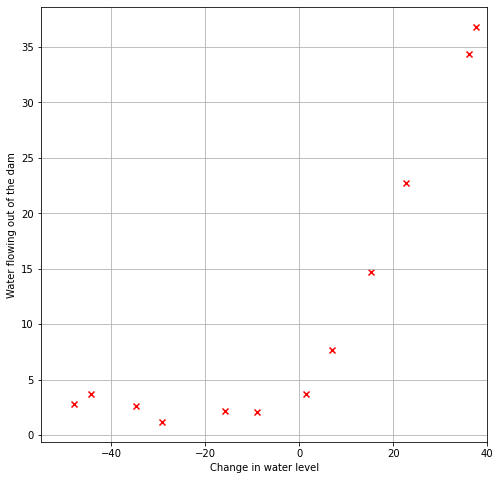

In [6]:
def plot(X,y):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X, y, c="r", marker="x")
    ax.set_xlabel("Change in water level")
    ax.set_ylabel("Water flowing out of the dam")
    ax.grid(True)
    plt.xlim(-55,40)
plot(raw_X,raw_y)

### 数据初始化

In [7]:
X = np.insert(raw_X,0,1,axis=1)
Xval = np.insert(raw_Xval,0,1,axis=1)
Xtest = np.insert(raw_Xtest,0,1,axis=1)
y = raw_y.flatten()
yval = raw_yval.flatten()
ytest = raw_ytest.flatten() 

In [8]:
X.shape,y.shape
Xval.shape,yval.shape
Xtest.shape,ytest.shape

((12, 2), (12,))

((21, 2), (21,))

((21, 2), (21,))

### Regularized linear regression cost function

In [9]:
def regularized_cost(theta,X,y,lamda):
    part1 = 1/(2*len(X))*np.sum(np.power(((X @ theta)-y),2))
    reg = lamda/(2*len(X)) * np.sum(np.power(theta[1:],2))
    return part1 + reg

### Regularized linear regression gradient

In [10]:
def regularized_gradient(theta,X,y,lamda):
    grad = (1/len(X)) * (X.T @ ((X @ theta)-y))
    reg = (lamda/len(X)) * theta
    reg[0] = 0
    return grad +reg

### Fitting linear regression

In [11]:
def trainLinearReg(X,y,lamda):
    theta = np.zeros(X.shape[1])
    result = opt.minimize(fun=regularized_cost, x0=theta, args=(X,y,lamda),method="TNC",
                         jac=regularized_gradient) 
    return result["x"]

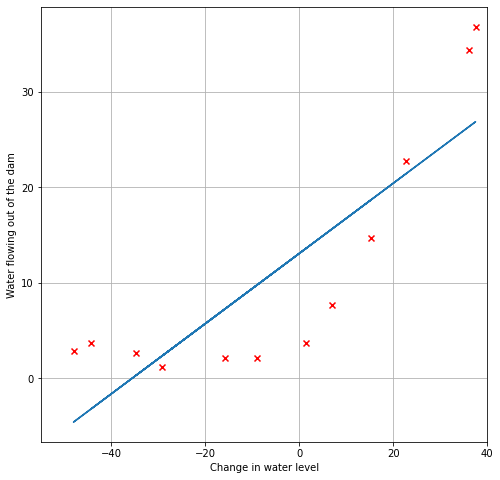

In [12]:
final_theta = trainLinearReg(X,y,0)#因为feature的数目很小，这么低的维度，可以不做regularization
plot(raw_X,raw_y)
plt.plot(X[:,1],X @ final_theta)

### Learning curves

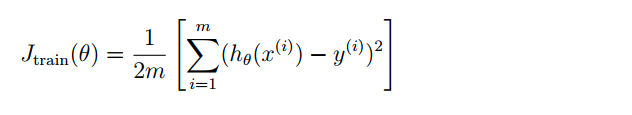

In [13]:
def Learning_curves(X,y,Xval,yval,lamda):
    training_cost, cv_cost = [], []
    seq = range(1,len(X)+1)
    for i in seq:
        theta = trainLinearReg(X[0:i,:],y[0:i],lamda)
        training_cost_i = regularized_cost(theta,X[0:i,:],y[0:i],0)#lamda=0 
        training_cost.append(training_cost_i)
        cv_cost_i = regularized_cost(theta,Xval,yval,0)
        cv_cost.append(cv_cost_i)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(seq,training_cost,label="training cost")
    ax.plot(seq,cv_cost,label="cv cost")
    ax.legend()
    ax.set_xlabel("Number of training examples")
    ax.set_ylabel("Error")
    ax.grid(True)
    plt.title("Learning curves")

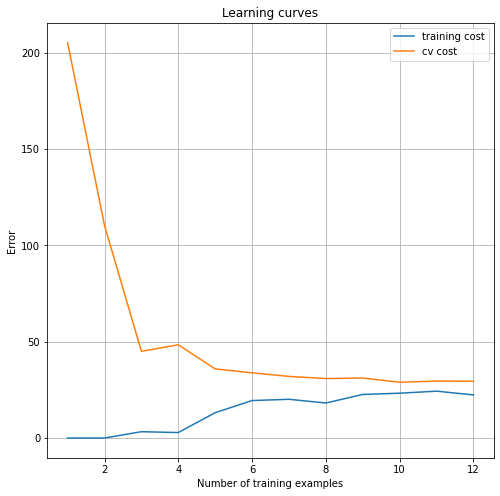

In [14]:
Learning_curves(X,y,Xval,yval,0)

两者趋近且误差较大，属于high bias

### Polynomial regression

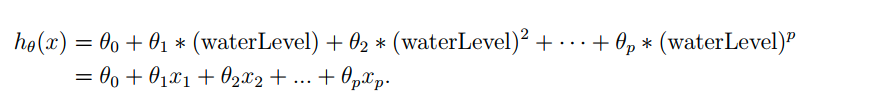

In [15]:
def Polyfeatures(X,power):
    Xploy = X.copy()
    for i in range(2,power+1):
        Xploy = np.insert(Xploy,Xploy.shape[1],np.power(Xploy[:,0],i),axis=1)
    return Xploy

In [16]:
def get_mean_std(X):
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0,ddof=1) #ddof=1意味着分母为n-1，不加则默认为n
    return means, stds

In [17]:
def featurescaling(X,mean,std):
    X_scaled = (X-mean)/std
    return X_scaled

In [18]:
power = 6
train_means, train_stds = get_mean_std(Polyfeatures(raw_X,power))
X_poly = featurescaling(Polyfeatures(raw_X,power),train_means,train_stds)
Xval_poly = featurescaling(Polyfeatures(raw_Xval,power),train_means,train_stds)
Xtest_poly = featurescaling(Polyfeatures(raw_Xtest,power),train_means,train_stds)

### 变量初始化

In [19]:
X_poly = np.insert(X_poly,0,1,axis=1)
Xval_poly = np.insert(Xval_poly,0,1,axis=1)
Xtest_poly = np.insert(Xtest_poly,0,1,axis=1) 

In [20]:
X_poly.shape,y.shape
Xval_poly.shape,yval.shape
Xtest_poly.shape,ytest.shape

((12, 7), (12,))

((21, 7), (21,))

((21, 7), (21,))

### Visualizing polynomial regression

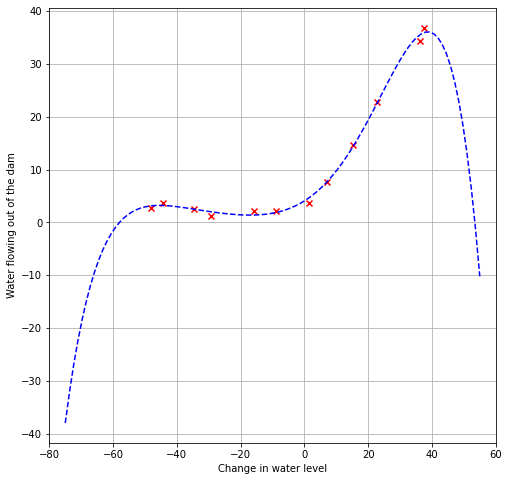

In [21]:
def plot_polynomial(X, y, lamda):
    theta = trainLinearReg(X, y, lamda)
    x = np.linspace(-75,55,100) #
    xmat = x.reshape(-1, 1)
    xmat = Polyfeatures(xmat, power)
    xmat_scaled = featurescaling(xmat, train_means, train_stds)
    xmat_scaled = np.insert(xmat_scaled,0,1,axis=1)
    
    plot(raw_X,raw_y)
    plt.plot(x, xmat_scaled @ theta,'b--')
    plt.xlim(-80,60)
plot_polynomial(X_poly,y,0)

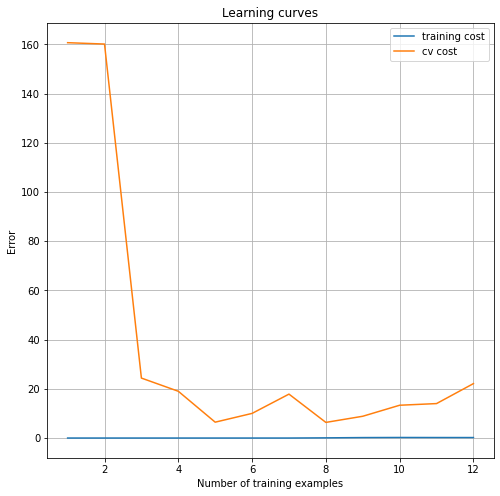

In [22]:
Learning_curves(X_poly,y,Xval_poly,yval,0)

training cost 都为0了，说明当λ=0的时候存在严重的overfitting

### λ  = 1

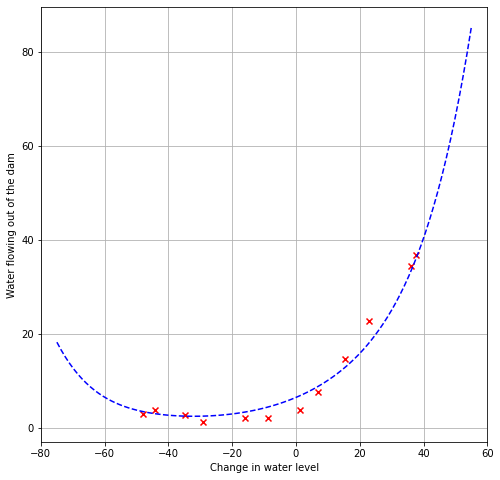

In [23]:
plot_polynomial(X_poly,y,1)

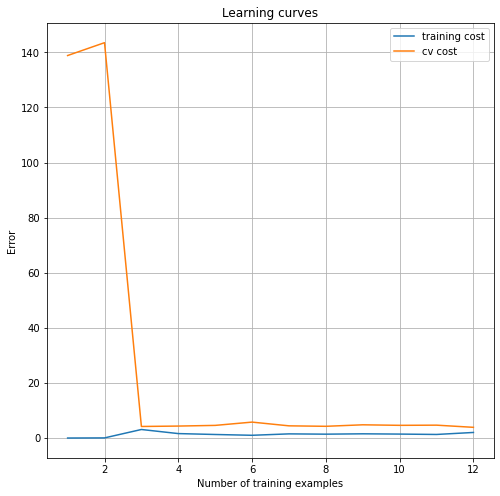

In [24]:
Learning_curves(X_poly,y,Xval_poly,yval,1)

Look nice！

### λ  = 100

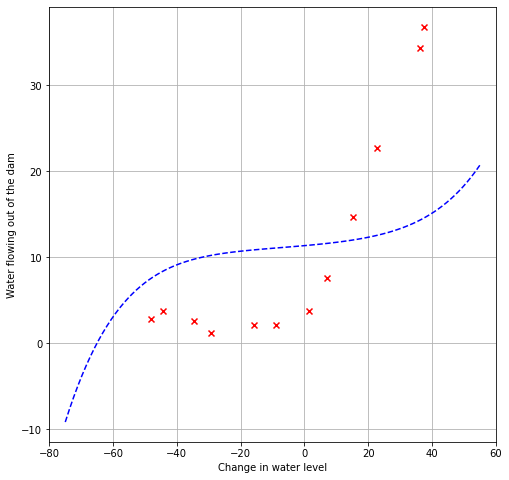

In [25]:
plot_polynomial(X_poly,y,100)

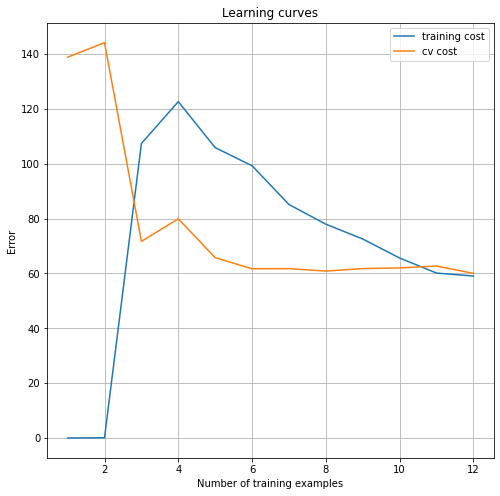

In [26]:
Learning_curves(X_poly,y,Xval_poly,yval,100)

Extremely underfit

### Selecting λ using the cross validation set

In [27]:
lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
errors_train, errors_val = [], []
for l in lambdas:
    theta = trainLinearReg(X_poly,y,l)
    errors_train.append(regularized_cost(theta,X_poly,y,0)) #不带惩罚项
    errors_val.append(regularized_cost(theta,Xval_poly,yval,0))

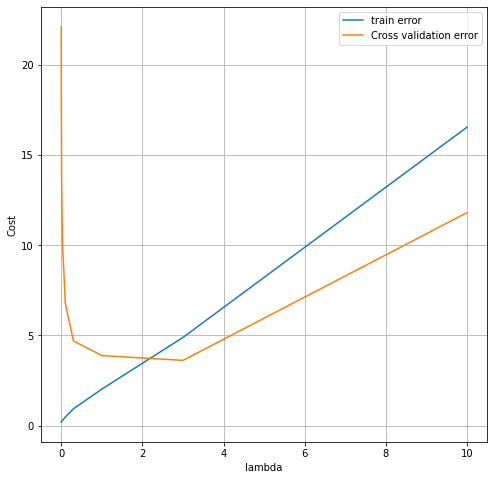

In [28]:
def lamdaplot():
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(lambdas,errors_train,label="train error")
    ax.plot(lambdas,errors_val,label="Cross validation error")
    ax.legend()
    ax.set_xlabel("lambda")
    ax.set_ylabel("Cost")
    ax.grid(True)
lamdaplot()

λ = 3 is the reasonable choice

### Compute test set error (estimator for prediction error)

In [29]:
fitted_theta = trainLinearReg(X_poly,y,3)
print("Test error(lambda={}) = {} ".format(3,regularized_cost(fitted_theta, Xtest_poly, ytest,0)))

Test error(lambda=3) = 4.755271952903141 


### Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

In [30]:
def Randomly_Learning_curves(X,y,Xval,yval,lamda,repetition):
    training_cost, cv_cost = np.zeros(X.shape[0]), np.zeros(X.shape[0])
    seq = range(1,len(X)+1)
    for i in seq:
        for j in range(repetition):  #每次抽取i个样本，重复多次取平均
            kk = np.random.choice(np.arange(X.shape[0]),i)
            theta = trainLinearReg(X[kk,:],y[kk],lamda)
            training_cost_i = regularized_cost(theta,X[kk,:],y[kk],0)
            training_cost[i-1] = training_cost[i-1]+training_cost_i
            cv_cost_i = regularized_cost(theta,Xval,yval,0)
            cv_cost[i-1] = cv_cost[i-1]+cv_cost_i
    training_cost = training_cost/repetition
    cv_cost = cv_cost/repetition
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(seq,training_cost,label="training cost")
    ax.plot(seq,cv_cost,label="cv cost")
    ax.legend()
    ax.set_xlabel("Number of training examples")
    ax.set_ylabel("Error")
    ax.grid(True)
    plt.title("Learning curves")

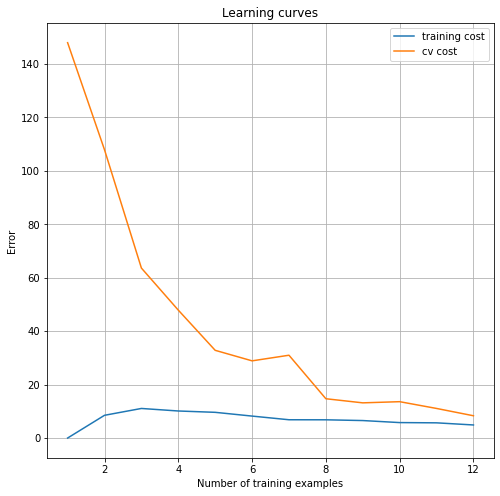

In [31]:
Randomly_Learning_curves(X_poly,y,Xval_poly,yval,3,50)